In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import models, layers, callbacks

In [2]:
# Checking GPU 

print(tf.test.gpu_device_name())

/device:GPU:0


In [3]:
# CONSTANTS

IMAGE_SIZE=256
BATCH_SIZE=32
EPOCHS=50
CHANNELS=3
TRAIN_SIZE=0.7
VALIDATION_SIZE=0.15
TEST_SIZE=0.15


In [4]:
# LOADING IMAGES

data = tf.keras.preprocessing.image_dataset_from_directory(
    directory="Plantvillage/_Tomato",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,

)

print("\n""Class names:", data.class_names)


Found 6627 files belonging to 4 classes.

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


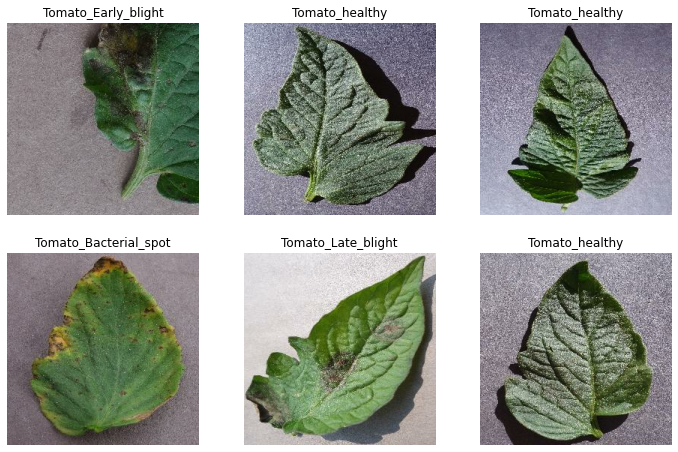

In [5]:
# Printing 6 images from the batch

plt.figure(figsize=(12,12))

for image_batch, label_batch in data.take(1):
    for i in range(6):
        plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(data.class_names[label_batch[i]])
        plt.axis("off")

In [6]:
# Splitting data for train, validation and test

def train_test_split(data, TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE):

    train_data = data.take(int(TRAIN_SIZE * len(data)))
    validation_data = data.skip(int(TRAIN_SIZE * len(data))).take(int(VALIDATION_SIZE * len(data)))
    test_data = data.skip(int(TRAIN_SIZE * len(data))).skip(int(VALIDATION_SIZE * len(data)))
    
    return train_data, validation_data, test_data

train_data, validation_data, test_data = train_test_split(data, TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE)

print("Length of train data:",len(train_data))
print("Length of validation data:",len(validation_data))
print("Length of test data:",len(test_data))


Length of train data: 145
Length of validation data: 31
Length of test data: 32


In [7]:
# Caching and pre-fetching data

train_data = train_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Pre-processing and augmentation

resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
])

data_augment = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [9]:
# creating model

INPUT_SHAPE=(1,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=len(data.class_names)

model = tf.keras.models.Sequential([
    resize_rescale,
    data_augment,
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),input_shape=INPUT_SHAPE),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),input_shape=INPUT_SHAPE),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, (3,3), kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape=INPUT_SHAPE)
model.compile(
    loss=['SparseCategoricalCrossentropy'], 
    metrics=['accuracy'], 
    optimizer='adam')

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (1, 256, 256, 3)          0         
_________________________________________________________________
sequential_1 (Sequential)    (1, 256, 256, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (1, 254, 254, 64)         1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 127, 127, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 125, 125, 64)         36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 62, 62, 64)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 60, 60, 64)          

In [12]:
# Training the model with earlystopping 

early_stop=callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0, mode='min')
tf.autograph.set_verbosity(0)

history = model.fit(
    train_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_data,
    callbacks=[early_stop]
)

Epoch 1/50
145/145 [==============================] - 18s 97ms/step - loss: 1.2469 - accuracy: 0.4672 - val_loss: 1.1250 - val_accuracy: 0.4919
Epoch 2/50
145/145 [==============================] - 12s 83ms/step - loss: 0.9102 - accuracy: 0.6310 - val_loss: 0.8621 - val_accuracy: 0.6300
Epoch 3/50
145/145 [==============================] - 11s 79ms/step - loss: 0.7880 - accuracy: 0.6894 - val_loss: 0.8383 - val_accuracy: 0.6472
Epoch 4/50
145/145 [==============================] - 11s 79ms/step - loss: 0.6908 - accuracy: 0.7250 - val_loss: 0.7924 - val_accuracy: 0.6734
Epoch 5/50
145/145 [==============================] - 11s 79ms/step - loss: 0.6263 - accuracy: 0.7563 - val_loss: 0.5552 - val_accuracy: 0.7893
Epoch 6/50
145/145 [==============================] - 11s 79ms/step - loss: 0.5627 - accuracy: 0.7849 - val_loss: 0.4807 - val_accuracy: 0.8216
Epoch 7/50
145/145 [==============================] - 11s 79ms/step - loss: 0.5284 - accuracy: 0.8054 - val_loss: 0.4614 - val_accuracy:

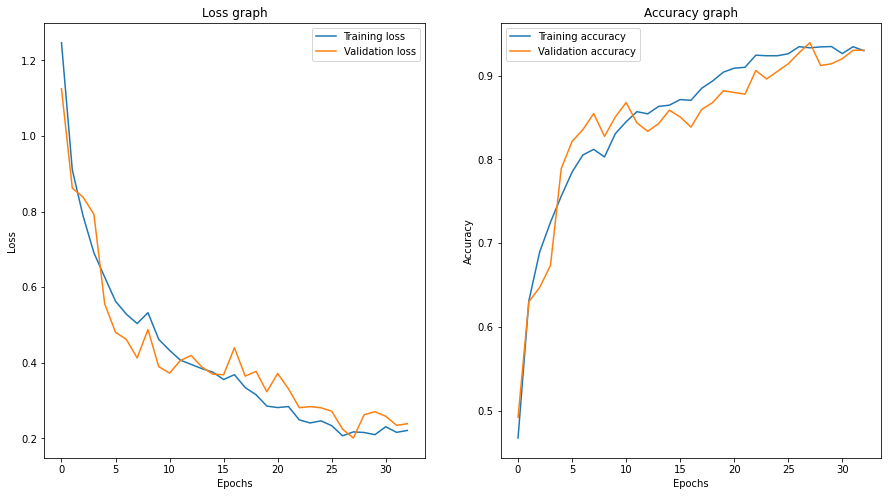

In [13]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(range(len(history.history['loss'])), history.history['loss'], label="Training loss")
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label="Validation loss")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss graph')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label="Training accuracy")
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label="Validation accuracy")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy graph')
plt.legend()

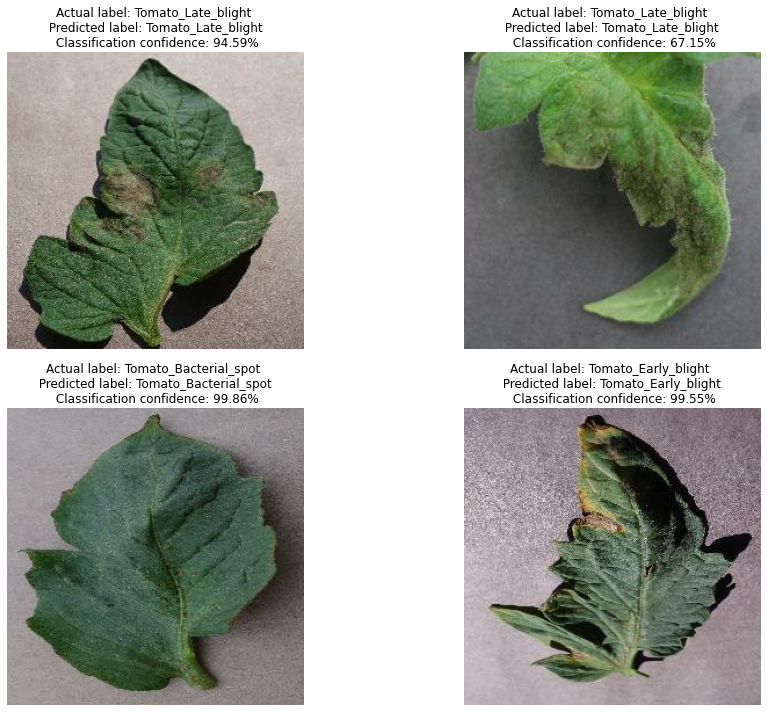

In [16]:
# Image prediction

def prediction(model,img):
    
    prediction_prob_list = model.predict(img)
    predicted_class = data.class_names[np.argmax(prediction_prob_list)]
    predicted_probability = round(np.max(prediction_prob_list)*100,2)
    
    return (predicted_class, predicted_probability)

for image_batch, label_batch in test_data.take(1):
    
    plt.figure(figsize=(15,12))
    
    for j in range(4):
        
        plt.subplot(2,2,j+1)
        predicted_class, predicted_probability = prediction(model, image_batch[j].numpy().reshape(INPUT_SHAPE))
        plt.imshow(image_batch[j].numpy().astype('uint8'))
        plt.title('Actual label: {} \n Predicted label: {} \n Classification confidence: {}%'.format(data.class_names[label_batch[j]], predicted_class, predicted_probability))
        plt.axis('off')

In [15]:
# Saving models

SAVE_PATH="./Saved_models/Tomato/"

if os.listdir(SAVE_PATH):
    model_version = int(max([i for i in os.listdir(SAVE_PATH)]))+1
else:
    model_version=1

model.save(SAVE_PATH+str(model_version))

INFO:tensorflow:Assets written to: ./Saved_models/Tomato/7\assets
